As per this Problem Statement, the objective of this project is to
build a model to detect whether a sentence is sarcastic or not, using **Bidirectional LSTMs**

***Importing Necessary Libraries***

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from tensorflow.keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from string import punctuation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional
from tensorflow import keras
import gensim
import warnings
warnings.filterwarnings("ignore")


***Loading Dataset***

In [ ]:




X ="/content/drive/MyDrive/Sarcasm_Headlines_Dataset.json"
class Loader():

    
    def __init__(self,lines):
        self.lines = lines
        
        print("Loading DF")
        
    def load_json_files(self,X):
        df = pd.read_json(X,lines=True)
        return df


In [ ]:
load= Loader(True)
df = load.load_json_files(X)
df.shape


Loading DF


(28619, 3)

In [ ]:
df = df[['headline','is_sarcastic']]
df.head()


,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


***Data Preprocessing***

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
Punctuation = list(string.punctuation)
STOPWORDS.update(Punctuation)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
class  Cleaning_Duty():
    
    
    
    def __init__(self):
        
        
        print("Project Clean Initiated")
        
        
        
    def strip_html(self,text):
        
        """
        Parsing the 
        text with BS4
        """
        
        soup = BeautifulSoup(text, "html.parser")
        
        return soup.get_text()

    
    def remove_between_square_brackets(self,text):
        
        """
        Removing the 
        square brackets
        """
        
        return re.sub('\[[^]]*\]', '', text)
    

    def remove_between_square_brackets(self,text):
        """
        Removing URL's
        """
        return re.sub(r'http\S+', '', text)
    

    def remove_stopwords(self,text):
        
        """
        Removing the 
        stopwords from text
        """
        
        final_text = []
        
        for i in text.split():
            
            if i.strip().lower() not in STOPWORDS:
                
                final_text.append(i.strip())
                
        return " ".join(final_text)

    
    def denoise_text(self,text):
        
        """
        Removing the 
        noisy text
        """
        
        text = self.strip_html(text)
        
        text = self.remove_between_square_brackets(text)
        
        text = self.remove_stopwords(text)
        
        return text
    
    def Apply_denoise_text(self):
    
        """ 
        Apply function 
        on review column
        """
        return df['headline'].apply(self.denoise_text)


In [ ]:
ZSJL = Cleaning_Duty()

Project Clean Initiated


In [ ]:
df['headline'] = ZSJL.Apply_denoise_text()
df.head()


,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails congress falling short ...,0
2,eat veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar getting work,1
4,mother comes pretty close using word 'streamin...,1


***Applying Wordcloud***

Now we will be applying a word cloud (also called tag cloud or weighted list) is a visual representation of text data. Words are usually single words, and the importance of each is shown with font size or color.


In [ ]:
def wordcloud(Z,num):
    plt.figure(figsize=(14, 10))
    wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(df[df.is_sarcastic == num].headline))
    plt.imshow(wordcloud)
    plt.axis("off")
    return wordcloud


When Sarcastic = 0 <wordcloud.wordcloud.WordCloud object at 0x7f1ee75915d0>
When Sarcastic = 1 <wordcloud.wordcloud.WordCloud object at 0x7f1ee80af450>


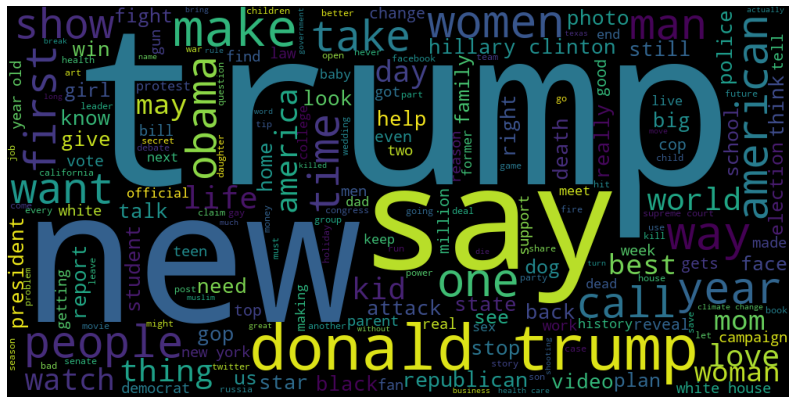

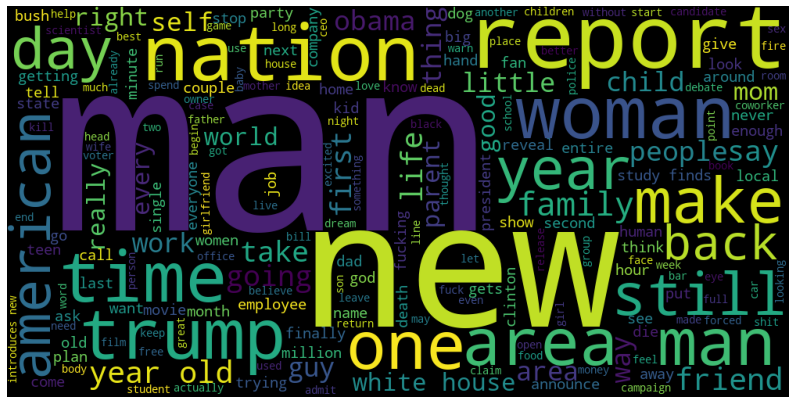

In [ ]:
print("When Sarcastic = 0",wordcloud(df,0))
print("When Sarcastic = 1",wordcloud(df,1))


***Word2Vec Embedding***


In [ ]:
class Word_Embedding():
    
    
    def __init__(self,
                 
                 size,
                 
                 window,
                 
                 min_count):
        
        self.size = 200
        
        self.window = 5
        
        self.min_count = 1
        
        
        
        print("Embedding Object Created")
        
        
    def Word_Embedding(self,df):
    
        words = []
        
        for i in df.headline.values:
            
            words.append(i.split())
            
        w2v_model = gensim.models.Word2Vec(sentences = words,size = self.size , window = self.window , min_count = self.min_count)
        
        return w2v_model,words
    
    def Tokenization_of_Wodrs(self,words,num_words):
    
        tokenizer = text.Tokenizer(num_words=num_words)
        
        tokenizer.fit_on_texts(words)
        
        tokenized_train = tokenizer.texts_to_sequences(words)
        
        x = sequence.pad_sequences(tokenized_train, maxlen = 20)
        
        vocab = tokenizer.word_index
        
        vocab_size = len(tokenizer.word_index) + 1
        
        return x,vocab,vocab_size
    
    def get_weight_matrix(self,model, vocab, EMBEDDING_DIM):

        vocab_size = len(vocab) + 1

        weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

        for word, i in vocab.items():
            
            weight_matrix[i] = model[word]
            
        return weight_matrix


In [ ]:
WE = Word_Embedding(200,5,1)


Embedding Object Created


In [ ]:
w2v_model,words = WE.Word_Embedding(df)


In [ ]:
x,vocab,vocab_size = WE.Tokenization_of_Wodrs(words,35000)


In [ ]:
embedding_vectors = WE.get_weight_matrix(w2v_model,vocab,200)


***Train-Test Split***

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0)


In [ ]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape


((20033, 20), (8586, 20), (20033,), (8586,))

***Bi-directional LSTM Model***

In [ ]:
input_length =20
output_length= 200
def build_rnn(vocab_size,output_dim, max_len):

    model = Sequential([
        keras.layers.Embedding(vocab_size,output_dim=output_length,
                              input_length=input_length),
        keras.layers.BatchNormalization(),
        keras.layers.Bidirectional(keras.layers.LSTM(256,return_sequences=True)),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(256),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(158),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(90),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(60),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32),
        keras.layers.Dense(output_dim, activation='sigmoid')
    ])

    return model

rnn_model = build_rnn(vocab_size, 1, input_length)

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

rnn_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 200)           7614400   
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 200)           800       
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 512)           935936    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 158)               4

In [ ]:
rnn_model.fit(x_train, y_train, batch_size = 256 , validation_data = (x_test,y_test) , epochs = 50)

score = rnn_model.evaluate(x_train, y_train, verbose=1)

print("Loss:%.3f Accuracy: %.3f" % (score[0], score[1]))


Epoch 1/50
79/79 [==============================] - 79s 949ms/step - loss: 0.6812 - acc: 0.5972 - val_loss: 0.6664 - val_acc: 0.5471
Epoch 2/50
79/79 [==============================] - 75s 945ms/step - loss: 0.2416 - acc: 0.9078 - val_loss: 0.5899 - val_acc: 0.7878
Epoch 3/50
79/79 [==============================] - 74s 934ms/step - loss: 0.0618 - acc: 0.9783 - val_loss: 0.5158 - val_acc: 0.7986
Epoch 4/50
79/79 [==============================] - 71s 905ms/step - loss: 0.0289 - acc: 0.9913 - val_loss: 0.4460 - val_acc: 0.7943
Epoch 5/50
79/79 [==============================] - 71s 894ms/step - loss: 0.0218 - acc: 0.9933 - val_loss: 0.5324 - val_acc: 0.7959
Epoch 6/50
79/79 [==============================] - 70s 892ms/step - loss: 0.0075 - acc: 0.9972 - val_loss: 0.6664 - val_acc: 0.7978
Epoch 7/50
79/79 [==============================] - 71s 898ms/step - loss: 0.0086 - acc: 0.9971 - val_loss: 1.0110 - val_acc: 0.7947
Epoch 8/50
79/79 [==============================] - 71s 903ms/step - 

***Model Evaluation***

In [ ]:
ypred = rnn_model.predict_classes(x_test)
ypred = pd.DataFrame(ypred,columns=['pred'])
ypred.head()


,pred
0,1
1,0
2,1
3,0
4,1


In [ ]:
ypred.shape,y_test.shape,x_test.shape


((8586, 1), (8586,), (8586, 20))

In [ ]:
ypred.value_counts()


pred
0       4460
1       4126
dtype: int64

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(metrics.accuracy_score(y_test, ypred))
        
print(metrics.confusion_matrix(y_test, ypred))
        
print(metrics.classification_report(y_test, ypred))


0.791521080829257
[[3615  945]
 [ 845 3181]]
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      4560
           1       0.77      0.79      0.78      4026

    accuracy                           0.79      8586
   macro avg       0.79      0.79      0.79      8586
weighted avg       0.79      0.79      0.79      8586

